Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline

import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filename)
    else:
        print(statinfo.st_size)
        raise ValueError(
            'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [4]:
vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5240, 3083, 12, 6, 195, 2, 3137, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

In [43]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    """
    Returns a training batch. Two vectors of the same length: batch & labels
    Paired labels with batch and the result is a list of tuples context & target.
    
    batch_size = Output size.
    num_skips = How many times to reuse an input to generate a label.
    skip_window = How many words to consider left and right.
    """
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])
    print('    paired:', list(zip( [reverse_dictionary[li] for li in labels.reshape(8)],
                                 [reverse_dictionary[bi] for bi in batch])))



data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'a', 'originated', 'as', 'term', 'a', 'of']
    paired: [('as', 'originated'), ('anarchism', 'originated'), ('a', 'as'), ('originated', 'as'), ('as', 'a'), ('term', 'a'), ('a', 'term'), ('of', 'term')]

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['a', 'originated', 'term', 'anarchism', 'as', 'originated', 'term', 'of']
    paired: [('a', 'as'), ('originated', 'as'), ('term', 'as'), ('anarchism', 'as'), ('as', 'a'), ('originated', 'a'), ('term', 'a'), ('of', 'a')]


Train a skip-gram model.

In [44]:
from tensorflow.python.framework import ops
ops.reset_default_graph()

batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
    # Variables.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

    # Optimizer.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [46]:
num_steps = 100001
sgram_losses = [] 

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(
            batch_size, num_skips, skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            sgram_losses.append(average_loss)
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 100000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.457585
Nearest to states: zinoviev, terrier, decade, abortive, owns, mahesh, legalized, disliked,
Nearest to be: donovan, rallying, champaign, vpi, transshipment, laodiceans, portrayal, conectiva,
Nearest to b: dativus, debrecen, avi, ap, clique, satisfying, perceptive, inbound,
Nearest to were: gustavus, salazar, hydrographic, manga, pushkin, stereoisomers, harshness, call,
Nearest to will: upwelling, boxes, universes, therus, tor, fingernails, sq, awkward,
Nearest to so: corrects, playground, earths, favorite, implementations, skyview, windward, obliquely,
Nearest to about: acupuncture, campo, backlit, ghazni, searching, pebble, salads, incapable,
Nearest to system: misguided, excessively, liberation, upheaval, confronting, wonders, ozzie, tines,
Nearest to one: painkillers, logged, yellowstone, sturluson, panda, kpd, intercal, sledge,
Nearest to people: usurp, toni, capitan, canoe, maroon, waterline, egyptologists, cleaner,
Nearest to however: k

In [8]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

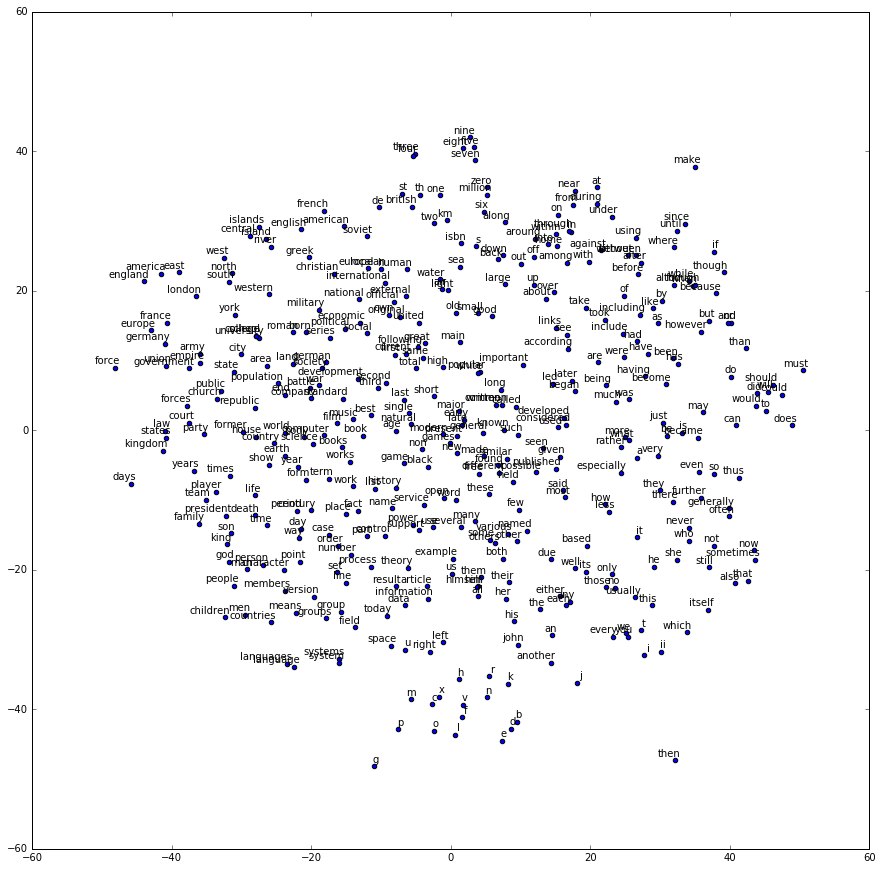

In [9]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                        ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

Lo de skip_window no creo que esté bien.

In [38]:
data_index = 0

def generate_cbow_batch_2(batch_size, skip_window):
    """
    Returns a training batch. Two vectors of the same length: batch & labels.
    batch is 2*batch_size. labels is batch_size.
    
    batch_size = Output size.
    skip_window = How many words to consider left and right.b
    """
    global data_index
    batches = np.ndarray(shape=(batch_size, 2*skip_window), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    batch_slice = batch_size + 2*skip_window
    curr_batch = data[data_index:data_index + batch_slice]
    window_slice = 2 * skip_window + 1
    for i in range(batch_size):
        window = curr_batch[i:i+window_slice]
        target_index = int(len(window) / 2)
        labels[i, 0] = window[target_index]
        batch_idx = 0
        for j in range(1, skip_window + 1):
            batches[i, batch_idx] = window[target_index - j]
            batch_idx += 1
            batches[i, batch_idx] = window[target_index + j]
            batch_idx += 1
    data_index += batch_slice
    if data_index > len(data):
        data_index = 0
    return batches, labels
    
print('data:', [reverse_dictionary[di] for di in data[:8]])

for skip_window in [ 1, 2]:
    data_index = 0
    batch, labels = generate_cbow_batch_2(8, skip_window)
    print('with skip_window =', skip_window)
    # print(batch)
    # print(labels)
    for i in range(len(batch)):
        print('    ', reverse_dictionary[batch[i, 0]], reverse_dictionary[batch[i, 1]], "->",
            reverse_dictionary[labels[i, 0]])


data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']
with skip_window = 1
     anarchism as -> originated
     originated a -> as
     as term -> a
     a of -> term
     term abuse -> of
     of first -> abuse
     abuse used -> first
     first against -> used
with skip_window = 2
     originated a -> as
     as term -> a
     a of -> term
     term abuse -> of
     of first -> abuse
     abuse used -> first
     first against -> used
     used early -> against


In [39]:
from tensorflow.python.framework import ops
ops.reset_default_graph()

batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size, 2])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
    # Variables.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
    # Model.
    # Look up embeddings for inputs.
    embed0 = tf.nn.embedding_lookup(embeddings, train_dataset[:, 0])
    embed1 = tf.nn.embedding_lookup(embeddings, train_dataset[:, 1])
    embed = embed0 + embed1

    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

    # Optimizer.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [40]:
num_steps = 100001
cbow_losses = []

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_cbow_batch_2(batch_size, skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            cbow_losses.append(average_loss)
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 100000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()


Initialized
Average loss at step 0: 7.803870
Nearest to th: orphaned, teaching, halos, newsweek, bitterness, campaign, regardless, numerically,
Nearest to new: subpixels, irrational, speech, wi, evoked, projection, cruciform, regenerated,
Nearest to in: birthplace, zebrafish, approaches, portugal, colonialism, publica, spectre, slovaks,
Nearest to two: hun, fricative, indiana, discordians, vice, hengest, batavian, auger,
Nearest to this: bisexuals, monophysite, questioning, gardnerian, louisiana, mallard, cursed, observance,
Nearest to can: kojiki, migrated, herder, distanced, aria, hardy, enters, falsehood,
Nearest to three: metaphor, diophantus, gautama, bacall, nadir, broadside, psychologically, shapeshifting,
Nearest to more: parkes, interrogated, kilograms, gardiner, koffice, lix, cantos, awarded,
Nearest to about: recall, hasty, gauge, dewan, dagobert, promulgate, glen, genes,
Nearest to were: andrade, twenty, ionosphere, forgetfulness, opengl, swamp, chesterfield, generous,
Near

In [32]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])


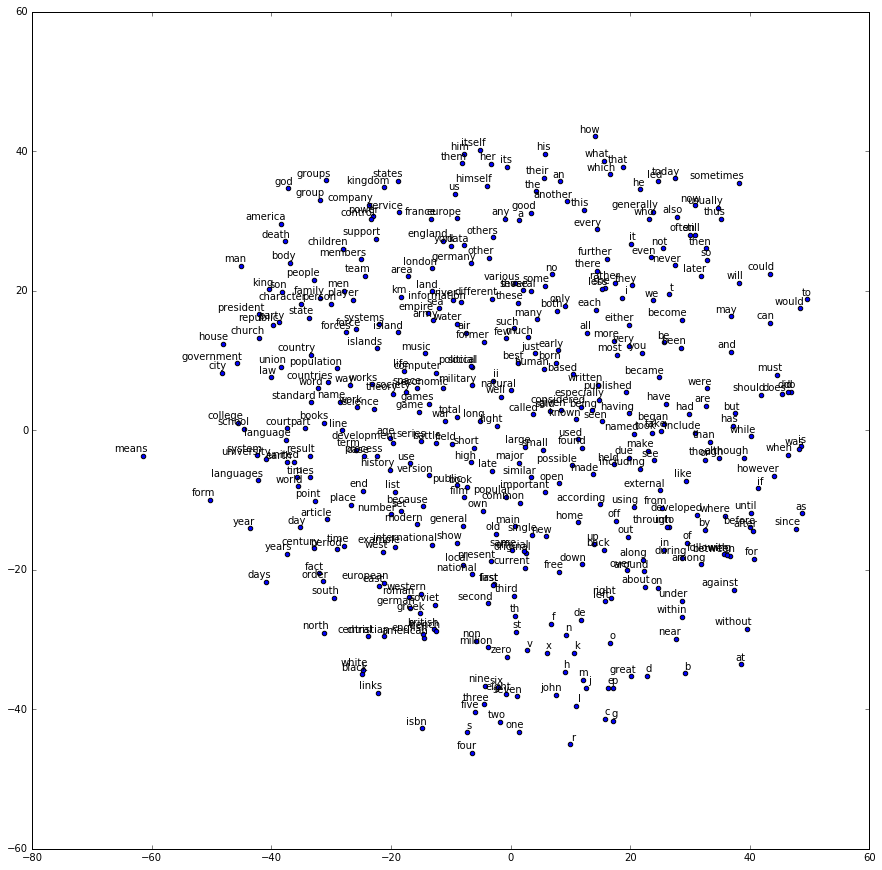

In [33]:
def plot2(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                        ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot2(two_d_embeddings, words)


---

Comparison between skip-gram and CBOW


[7.8038702011108398, 4.0945412055850028, 3.5555446722507478, 3.376493561565876, 3.2474609330594539, 3.1770919513702394, 3.1826615728437901, 3.1664527376294136, 3.1761356251090764, 3.1228267195820809, 2.9818005533814431, 3.076825576722622, 3.0518911036252976, 2.9813256270587445, 3.0292306703329088, 2.9962123257815838, 2.8732223504185677, 2.8970390633940695, 2.9460879195332526, 2.9649267246723174, 2.9025938642676921, 2.9540133749842643, 2.9566786963790657, 2.9112702289223673, 2.8738978831171988, 2.8591869777143, 2.867606450498104, 2.8451236771345139, 2.8899170004129409, 2.7280691957473753, 2.8453610237240792, 2.8364735967218877, 2.7942904204726218, 2.7438750569820405, 2.714098676085472, 2.7767130600512027, 2.7982663950920106, 2.7060197529792784, 2.726143712222576, 2.8117097866237164, 2.8131433166861535, 2.6667802211046219, 2.761047208428383, 2.714676046460867, 2.74586298507452, 2.7757748751044273, 2.6493032815754414, 2.7311656207144259, 2.7185496201515198, 2.5947911643981936, 2.260277029

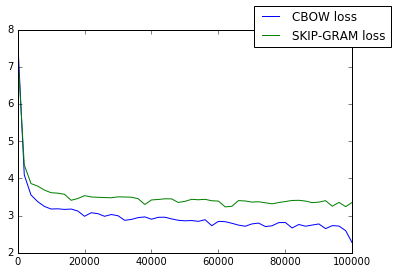

In [63]:
print(cbow_losses)
print(sgram_losses)
xaxis = list(range(0,102000,2000))

pl = pylab.plot(xaxis, cbow_losses, xaxis, sgram_losses)
pl = pylab.figlegend(pl, ('CBOW loss','SKIP-GRAM loss'), 'upper right')
